<a href="https://colab.research.google.com/github/pplantinga/ParkinsonSpeechAI/blob/main/Predictions_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook calculates some statistics over prediction.csv files for Parkinson's prediction

Import some libraries and unzip our predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
!unzip predictions.zip -d predictions

Archive:  predictions.zip
  inflating: predictions/all_predictions_ecapa_aam_weights_fullset.csv  
  inflating: predictions/all_predictions_ecapa_aam_weights_norepeats.csv  
  inflating: predictions/all_predictions_ecapa_aam_weights_norepeats_nofemales.csv  
  inflating: predictions/all_predictions_ecapa_aam_weights_norepeats_nomales.csv  
  inflating: predictions/all_predictions_ecapa_aam_weights_repeats_nofemales.csv  
  inflating: predictions/all_predictions_ecapa_aam_weights_repeats_nomales.csv  


In [ ]:
# Creates average index (label prediction) and average score (cosine similarity) columns
def update_predictions_df(df, columns):
  for index in df.index:
    for column in columns:
      # Create new average columns
      if index == 0:
        df[f"average of {column}"] = 0.0

      # Create a list out of string of predictions
      elements = df[column][index]
      elements = elements.strip("[]")
      elements = elements.split(", ")
      elements_list = [float(x) for x in elements]
      # Add to df
      df.loc[index, f"average of {column}"] = np.mean(elements_list)

In [ ]:
experiment_dfs = {}
for csv_file in os.listdir("predictions"):
  experiment_name = csv_file.split(".")[0].split("_")[2:]
  experiment_name = "_".join(experiment_name)
  print(f"Working on {experiment_name}")

  df = pd.read_csv(f"predictions/{csv_file}")
  update_predictions_df(df, ["indexes", "score"])
  experiment_dfs[experiment_name] = df

Working on ecapa_aam_weights_norepeats_nomales
Working on ecapa_aam_weights_norepeats
Working on ecapa_aam_weights_repeats_nofemales
Working on ecapa_aam_weights_fullset
Working on ecapa_aam_weights_repeats_nomales
Working on ecapa_aam_weights_norepeats_nofemales


In [ ]:
def calculate_accuracy_by_category(experiment_dfs, threshhold=0.5):
  """Calculates the accuracy for each category (M/F, EN/FR/Other, Age, etc) in the DataFrame.

  Args:
    experiment_dfs: A dictionary of dataframes with results for each experiment.

  Returns:
    A df with accuracy for each category and each experiment.
  """

  rows = []
  for experiment in experiment_dfs:
    # Get the df in the dict and create row list
    df = experiment_dfs[experiment]
    row = {'experiment': experiment}

    # Calculate the overall accuracy using a threshhold
    row['accuracy'] = ((df['average of indexes'] >= threshhold) == df['label']).mean()

    # Calculate the accuracy by category
    useful_categories = ['ptype', 'sex', 'l1', 'test'] # add updrs  and age eventually
    for category in useful_categories:
      # Get unique values in this category
      unique_values = df[category].unique()
      for value in unique_values:
        # Get the rows corresponding to this specific category
        df_category = df[df[category] == value]
        df_category.loc[:, 'correct'] = (df_category['average of indexes'] >= threshhold) == df_category['label']        # Calculate accuracy and add to row
        row[f'{value}_accuracy'] = df_category['correct'].mean()

    # Breakdown by PD and HC
    for ptype in df['ptype'].unique():
      for category in useful_categories[1:]:
        # Get unique values in this category
        unique_values = df[category].unique()
        for value in unique_values:
          # Find accuracy for entries that are both ptype and this category
          df_category = df[(df['ptype'] == ptype) & (df[category] == value)]
          df_category.loc[:, 'correct'] = (df_category['average of indexes'] >= threshhold) == df_category['label']
          row[f'{ptype}_{value}_accuracy'] = df_category['correct'].mean()

    rows.append(row)
  return pd.DataFrame(rows)

In [ ]:
accuracy_by_category = calculate_accuracy_by_category(experiment_dfs)

In [ ]:
accuracy_by_category = accuracy_by_category.sort_values(by='experiment')
print(accuracy_by_category.head)

<bound method NDFrame.head of                               experiment  accuracy  HC_accuracy  PD_accuracy  \
3              ecapa_aam_weights_fullset  0.654589     0.579808     0.730097   
1            ecapa_aam_weights_norepeats  0.714085     0.791429     0.638889   
5  ecapa_aam_weights_norepeats_nofemales  0.721127     0.765714     0.677778   
0    ecapa_aam_weights_norepeats_nomales  0.764789     0.817143     0.713889   
2    ecapa_aam_weights_repeats_nofemales  0.645894     0.632692     0.659223   
4      ecapa_aam_weights_repeats_nomales  0.650242     0.633654     0.666990   

   M_accuracy  F_accuracy  English_accuracy  Other_accuracy  French_accuracy  \
3    0.727723    0.584906          0.607792        0.649180         0.707527   
1    0.811594    0.621918          0.641379        0.734177         0.729412   
5    0.811594    0.635616          0.696552        0.713924         0.758824   
0    0.857971    0.676712          0.710345        0.784810         0.764706   
2    0.71

## Lets visualize our new accuracy scores!

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(df, columns):
    # Get the unique experiment names
    experiment_names = df['experiment'].unique()
    for i, name in enumerate(experiment_names):
      name = name.split("_")[-2:]

      if name[0] == "weights":
        experiment_names[i] = name[1]
      else:
        experiment_names[i] = "_".join(name)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the bar plot for each category
    x = range(len(experiment_names))
    bar_width = 0.8 / len(columns)

    # List of not ugly colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for i, column in enumerate(columns):
        ax.bar([x_pos + i * bar_width for x_pos in x], df[column], bar_width,
               label=column, color=colors[i])

    # Set the x-axis ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(experiment_names, rotation=0)

    # Set the y-axis range to be between 0.0 and 1.0
    ax.set_ylim(0.0, 1.0)

    # Set the y-axis label and title
    ax.set_ylabel('Accuracy')
    ax.set_title('Experiment Accuracy by Category')
    ax.legend()

    # Adjust the layout to prevent overlapping x-axis labels
    plt.tight_layout()

    # Show the plot
    plt.show()

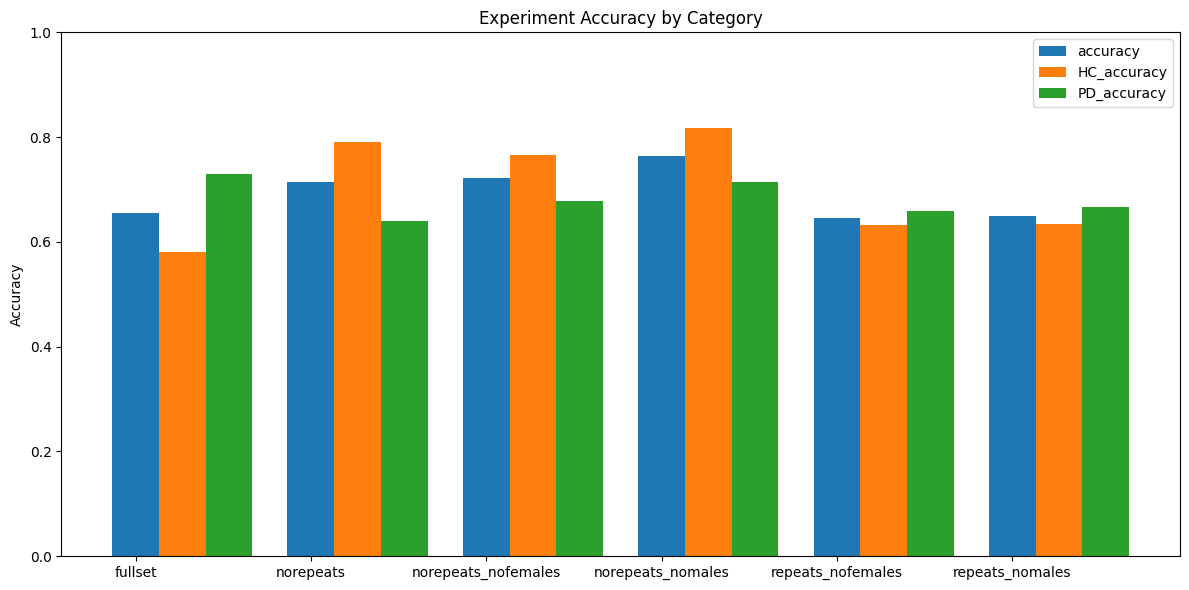

In [85]:
plot_metrics(accuracy_by_category, ['accuracy', 'HC_accuracy', 'PD_accuracy'])

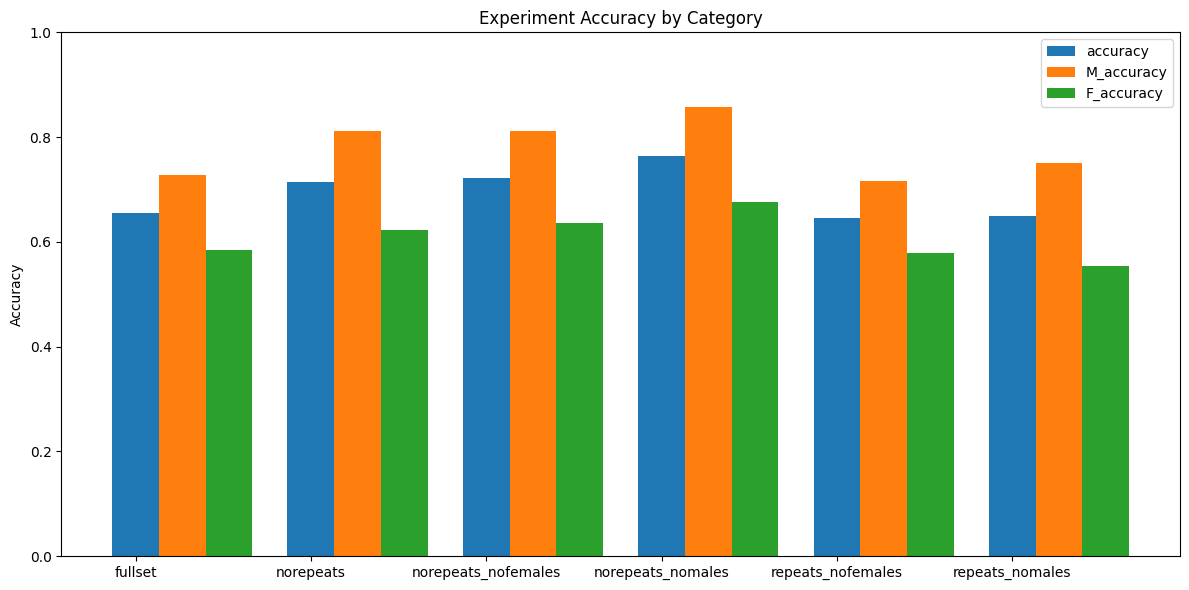

In [86]:
plot_metrics(accuracy_by_category, ['accuracy', 'M_accuracy', 'F_accuracy'])

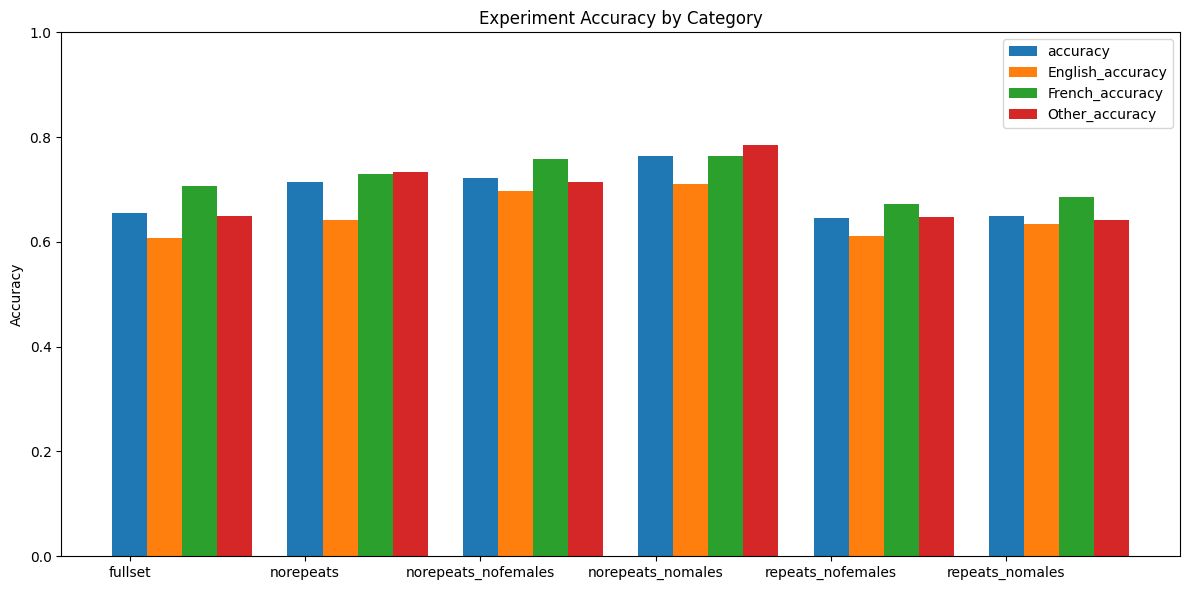

In [87]:
plot_metrics(accuracy_by_category, ['accuracy', 'English_accuracy', 'French_accuracy', 'Other_accuracy'])

In [88]:
print(accuracy_by_category.columns)

Index(['experiment', 'accuracy', 'HC_accuracy', 'PD_accuracy', 'M_accuracy',
       'F_accuracy', 'English_accuracy', 'Other_accuracy', 'French_accuracy',
       'recall_accuracy', 'dpt_accuracy', 'read_text_accuracy', 'hbd_accuracy',
       'HC_M_accuracy', 'HC_F_accuracy', 'HC_English_accuracy',
       'HC_Other_accuracy', 'HC_French_accuracy', 'HC_recall_accuracy',
       'HC_dpt_accuracy', 'HC_read_text_accuracy', 'HC_hbd_accuracy',
       'PD_M_accuracy', 'PD_F_accuracy', 'PD_English_accuracy',
       'PD_Other_accuracy', 'PD_French_accuracy', 'PD_recall_accuracy',
       'PD_dpt_accuracy', 'PD_read_text_accuracy', 'PD_hbd_accuracy',
       'repeat_accuracy', 'vowel_repeat_accuracy', 'HC_repeat_accuracy',
       'HC_vowel_repeat_accuracy', 'PD_repeat_accuracy',
       'PD_vowel_repeat_accuracy'],
      dtype='object')


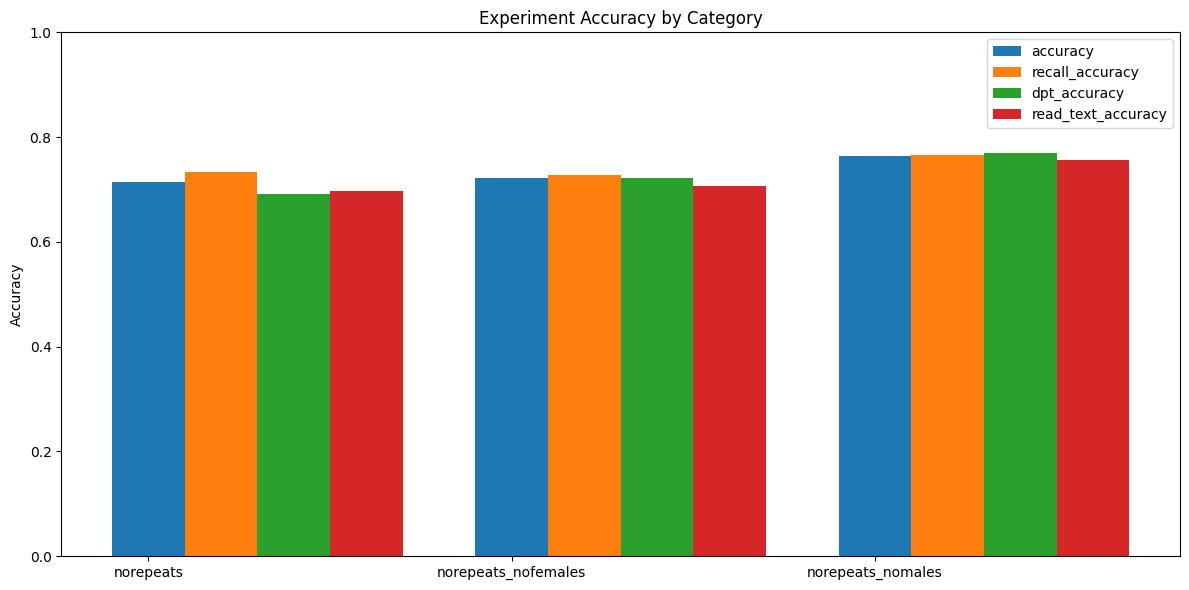

In [91]:
no_repeats_df = accuracy_by_category.drop([3, 2, 4], axis=0)
plot_metrics(no_repeats_df, ['accuracy', 'recall_accuracy', 'dpt_accuracy', 'read_text_accuracy'])

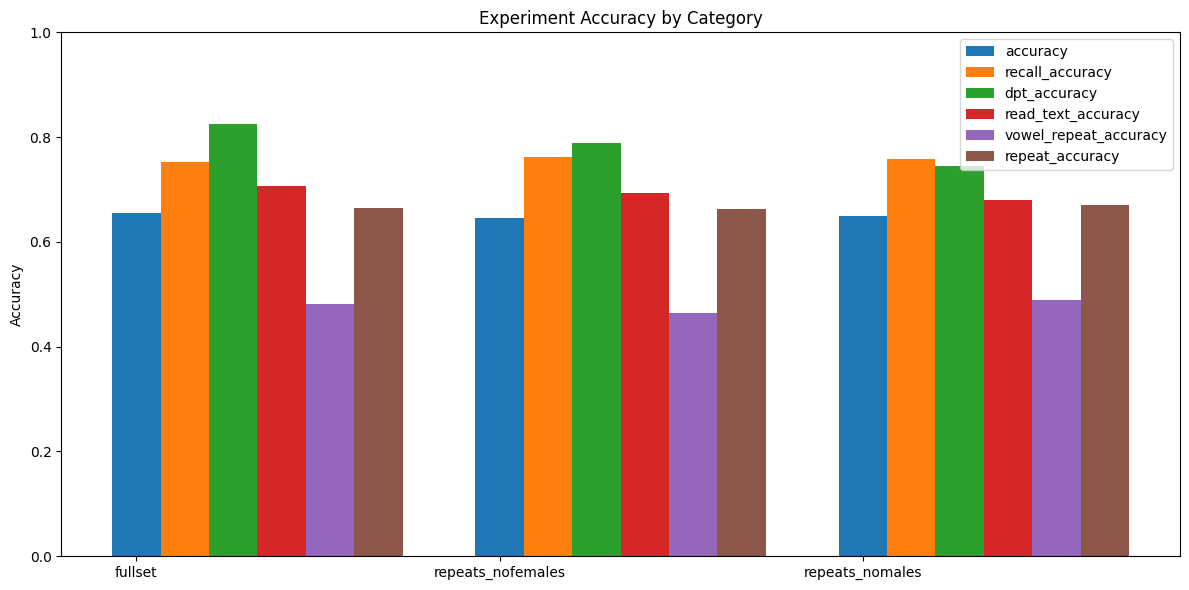

In [96]:
repeats_df = accuracy_by_category.drop([0, 1, 5], axis=0)
plot_metrics(repeats_df, ['accuracy', 'recall_accuracy', 'dpt_accuracy', 'read_text_accuracy', 'vowel_repeat_accuracy', 'repeat_accuracy'])